In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitl14.patch_size = 14 # The patch_size is already 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main


/tmp/ipykernel_714101/361466256.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(scaled_padded_crop_rgb).squeeze().permute(1,2,0))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


scaled_padded_crop_rgb.shape torch.Size([1, 3, 420, 420])


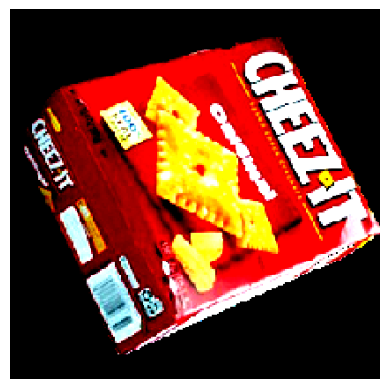

(900, 256)


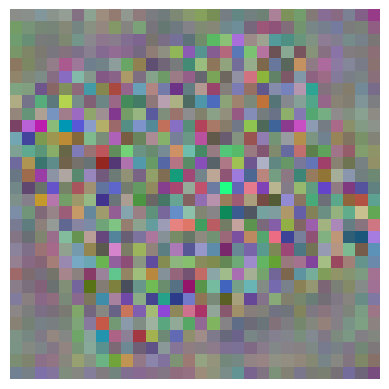

In [42]:
import torchvision.transforms as T
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def crop_feature_extraction(crop_rgb, dino_model):
    # crop_rgb: numpy array
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    inv_rgb_transform = T.Compose(
        [
            T.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
            ),
        ]
    )
    normalized_crop_rgb = rgb_normalize(crop_rgb).float()

    # Scale image to 420
    target_max = 420
    scale_factor = target_max / torch.max(torch.tensor(normalized_crop_rgb.shape)) # 420/max of x1,y1,x2,y2
    scaled_crop_rgb = F.interpolate(normalized_crop_rgb.unsqueeze(0), scale_factor=scale_factor.item())[0] # unsqueeze at  0 - B,C, H, W
    
    # Padding 0 to 3, 420, 420
    original_h, original_w = scaled_crop_rgb.shape[1:]
    original_ratio = original_w / original_h
    target_h, target_w = 420, 420
    target_ratio  = target_w/target_h 
    if  target_ratio != original_ratio: 
        padding_top = max((target_h - original_h) // 2, 0)
        padding_bottom = target_h - original_h - padding_top
        padding_left = max((target_w - original_w) // 2, 0)
        padding_right = target_w - original_w - padding_left
        scaled_padded_crop_rgb = F.pad(
        scaled_crop_rgb, (padding_left, padding_right, padding_top, padding_bottom)
        )
    else:
        scaled_padded_crop_rgb = scaled_crop_rgb
    scaled_padded_crop_rgb = scaled_padded_crop_rgb.unsqueeze(0) # unsqueeze to make it as a stack of proposals - here we use only 1 proposals
    print("scaled_padded_crop_rgb.shape", scaled_padded_crop_rgb.shape) 

    # Display the resized image 
    plt.imshow(torch.tensor(scaled_padded_crop_rgb).squeeze().permute(1,2,0))
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    layers_list = list(range(18))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dino_model.module.get_intermediate_layers(scaled_padded_crop_rgb.to(device), n=layers_list, return_class_token=True)

    pca = PCA(n_components=256)
    pca_crop_patches_descriptors = pca.fit_transform(np.array(feature_patches[-1][0].reshape(-1,1024).cpu()))
    print(pca_crop_patches_descriptors.shape)

    
    # pca = PCA(n_components=n_components).fit(descriptors[0, 0])
    # pca_descriptors = pca.transform(descriptors[0, 0])

    top3_pca = pca_crop_patches_descriptors.reshape(30,30,-1)[:,:,-3:]
    normalized_image = ((top3_pca - np.min(top3_pca)) / (np.max(top3_pca) - np.min(top3_pca))* 255).astype(np.uint8)

    # inv_transformed_top3_pca = inv_rgb_transform(torch.tensor(normalized_image).permute(2,0,1))

    # # Clip the values to ensure they are within the valid range [0, 255]
    # clipped_array = np.clip(inv_transformed_top3_pca*255, 0, 255)
    # top_pca_image = np.array(clipped_array).astype(np.uint8)

    # Display the image - 10* see lb the crop is normalized same way as the templates- ready to compare the similarity now
    plt.imshow(torch.tensor(normalized_image))# .permute(1,2,0))
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

    return top3_pca # Choose the last features as the feature after the 18th layer

# Load image crop 
crop_rgb = np.array(Image.open("foundpose_analysis/ycbv/templates/synthetic_images_templates/ycbv/train_pbr/obj_000002_original/000022.png").convert("RGB"))/255.0
top3_pca = crop_feature_extraction(crop_rgb, dinov2_vitl14 )

In [5]:
gray_scale = np.sum(top3_pca,-1)
gray_scale = gray_scale / 3
gray_scale.shape

(30, 30)

In [6]:
normalized_image = (gray_scale - np.min(gray_scale)) / (np.max(gray_scale) - np.min(gray_scale))

In [7]:
processed = [normalized_image]

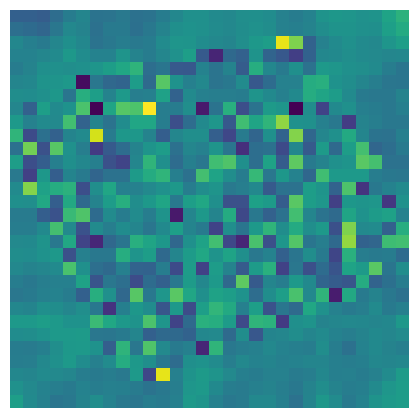

In [8]:
fig = plt.figure(figsize=(30, 30))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')